#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Dropout, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [7]:
def data_minmax(id):
    df = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == id)]
    df = df.merge(orders, how='left', on=['Date', 'Store_ID'])
    df = df.drop(['Store_ID', 'Product_ID'], axis = 1)

    df['y'] = df['Qty'].shift(-2)
    # df['y'] = df['y'].fillna(method='bfill')

    df = df.iloc[:-2]
    df = df.set_index('Date')

    return df['y'].max(), df['y'].min()

In [8]:
beverage = joblib.load(path+'train_data_3.pkl')
milk = joblib.load(path+'train_data_12.pkl')
agri = joblib.load(path+'train_data_42.pkl')

In [9]:
beverage

,Qty,CustomerCount,Qty_RM7,Qty_RM14,Customer_RM7,Customer_RM14,Qty_before_5d,Customer_before_5d,Qty_before_7d,Customer_before_7d,Weekend,Season_Spring,Season_Summer,Season_Winter,Holiday,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.340259
1,0.387715,0.529011,0.262753,0.336424,0.307749,0.348817,0.387715,0.529011,0.387715,0.529011,0.0,0.0,0.0,1.0,0.0,0.596270
2,0.340259,0.498505,0.328896,0.421114,0.398501,0.451679,0.340259,0.498505,0.340259,0.498505,0.0,0.0,0.0,1.0,0.0,0.614095
3,0.596270,0.638952,0.448717,0.574530,0.484729,0.549414,0.596270,0.638952,0.596270,0.638952,1.0,0.0,0.0,1.0,0.0,0.310865
4,0.614095,0.612872,0.525441,0.672766,0.530397,0.601176,0.614095,0.612872,0.614095,0.612872,1.0,0.0,0.0,1.0,0.0,0.282847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.309133,0.458667,0.508537,0.676995,0.554055,0.667275,0.374769,0.515492,0.309054,0.459385,0.0,0.0,0.0,1.0,0.0,0.401684
1146,0.315508,0.473143,0.509977,0.677975,0.554592,0.667264,0.642624,0.648164,0.308071,0.469913,0.0,0.0,0.0,1.0,0.0,0.486405
1147,0.401684,0.544204,0.515189,0.674663,0.559364,0.664751,0.473104,0.476851,0.374769,0.515492,0.0,0.0,0.0,1.0,0.0,0.397749
1148,0.486405,0.552578,0.484941,0.668229,0.543477,0.659714,0.236257,0.361048,0.642624,0.648164,1.0,0.0,0.0,1.0,0.0,0.393735


In [10]:
milk

,Qty,CustomerCount,Qty_RM7,Qty_RM14,Customer_RM7,Customer_RM14,Qty_before_5d,Customer_before_5d,Qty_before_7d,Customer_before_7d,Weekend,Season_Spring,Season_Summer,Season_Winter,Holiday,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.239287
1,0.259985,0.529011,0.228899,0.287978,0.307749,0.348817,0.259985,0.529011,0.259985,0.529011,0.0,0.0,0.0,1.0,0.0,0.382364
2,0.239287,0.498505,0.293051,0.368686,0.398501,0.451679,0.239287,0.498505,0.239287,0.498505,0.0,0.0,0.0,1.0,0.0,0.390503
3,0.382364,0.638952,0.388111,0.488281,0.484729,0.549414,0.382364,0.638952,0.382364,0.638952,1.0,0.0,0.0,1.0,0.0,0.205196
4,0.390503,0.612872,0.448014,0.563644,0.530397,0.601176,0.390503,0.612872,0.390503,0.612872,1.0,0.0,0.0,1.0,0.0,0.191991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.240689,0.458667,0.489818,0.616191,0.554055,0.667275,0.300571,0.515492,0.240527,0.459385,0.0,0.0,0.0,1.0,0.0,0.286477
1146,0.232927,0.473143,0.487574,0.615764,0.554592,0.667264,0.452568,0.648164,0.241848,0.469913,0.0,0.0,0.0,1.0,0.0,0.349755
1147,0.286477,0.544204,0.484028,0.616954,0.559364,0.664751,0.317496,0.476851,0.300571,0.515492,0.0,0.0,0.0,1.0,0.0,0.293726
1148,0.349755,0.552578,0.458165,0.618459,0.543477,0.659714,0.195278,0.361048,0.452568,0.648164,1.0,0.0,0.0,1.0,0.0,0.286153


In [11]:
agri

,Qty,CustomerCount,Qty_RM7,Qty_RM14,Customer_RM7,Customer_RM14,Qty_before_5d,Customer_before_5d,Qty_before_7d,Customer_before_7d,Weekend,Season_Spring,Season_Summer,Season_Winter,Holiday,y
0,0.039735,0.000000,0.000000,0.000000,0.000000,0.000000,0.039735,0.000000,0.039735,0.000000,0.0,0.0,0.0,1.0,1.0,0.192053
1,0.205298,0.529011,0.109238,0.111750,0.307749,0.351826,0.205298,0.529011,0.205298,0.529011,0.0,0.0,0.0,1.0,0.0,0.218543
2,0.192053,0.498505,0.139825,0.143040,0.398501,0.455576,0.192053,0.498505,0.192053,0.498505,0.0,0.0,0.0,1.0,0.0,0.284768
3,0.218543,0.638952,0.163858,0.167625,0.484729,0.554154,0.218543,0.638952,0.218543,0.638952,1.0,0.0,0.0,1.0,0.0,0.132450
4,0.284768,0.612872,0.195755,0.200255,0.530397,0.606363,0.284768,0.612872,0.284768,0.612872,1.0,0.0,0.0,1.0,0.0,0.218543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,0.178808,0.458667,0.367041,0.356322,0.554055,0.673032,0.423841,0.515492,0.172185,0.459385,0.0,0.0,0.0,1.0,0.0,0.304636
1149,0.350993,0.473143,0.367041,0.360153,0.554592,0.673020,0.317881,0.648164,0.350993,0.469913,0.0,0.0,0.0,1.0,0.0,0.397351
1150,0.304636,0.544204,0.344569,0.348020,0.559364,0.670486,0.423841,0.476851,0.423841,0.515492,0.0,0.0,0.0,1.0,0.0,0.417219
1151,0.397351,0.552578,0.359551,0.356322,0.543477,0.665405,0.205298,0.361048,0.317881,0.648164,1.0,0.0,0.0,1.0,0.0,0.218543


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [12]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mcp = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [14]:
X3 = beverage.drop('y', axis = 1)
y3 = beverage['y']

X3_train, X3_val, y3_train, y3_val = X3.iloc[:-60], X3.iloc[-60:], y3.iloc[:-60], y3.iloc[-60:]

In [15]:
X3_train_3d, y3_train_3d = temporalize(X3_train, y3_train, 7)
X3_valid_3d, y3_valid_3d = temporalize(X3_val, y3_val, 7)

* **모델링**

In [16]:
clear_session()

model3_lstm = Sequential()
model3_lstm.add(LSTM(64, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model3_lstm.add(Dense(32, activation='relu'))
model3_lstm.add(Dense(16, activation='relu'))
model3_lstm.add(Dense(1))

model3_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,105 (90.25 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model3_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model3_lstm.fit(X3_train_3d, y3_train_3d, epochs=50, batch_size=16, validation_data=(X3_valid_3d, y3_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0618
Epoch 1: val_loss improved from inf to 0.02239, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0613 - val_loss: 0.0224
Epoch 2/50
60/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 2: val_loss improved from 0.02239 to 0.01909, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0191
Epoch 3/50
60/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 3: val_loss improved from 0.01909 to 0.01177, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 4/50
65/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 4: val_loss improved from 0.01177 to 0.00990, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0099
Epoch 5/50
66/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 5: val_loss did not improve from 0.0099

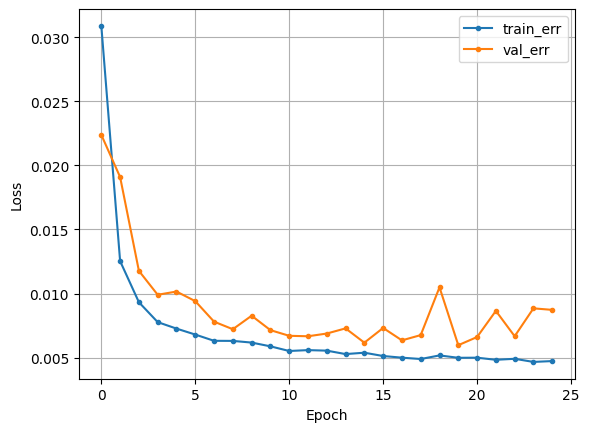

In [18]:
dl_history_plot(history.history)

In [19]:
y3_pred_lstm = model3_lstm.predict(X3_valid_3d)

# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y3_valid_3d, y3_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y3_valid_3d, y3_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y3_valid_3d, y3_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y3_valid_3d, y3_pred_lstm), 3)}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
RMSE : 0.093
MAE : 0.067
MAPE : 0.141
R2 : 0.583


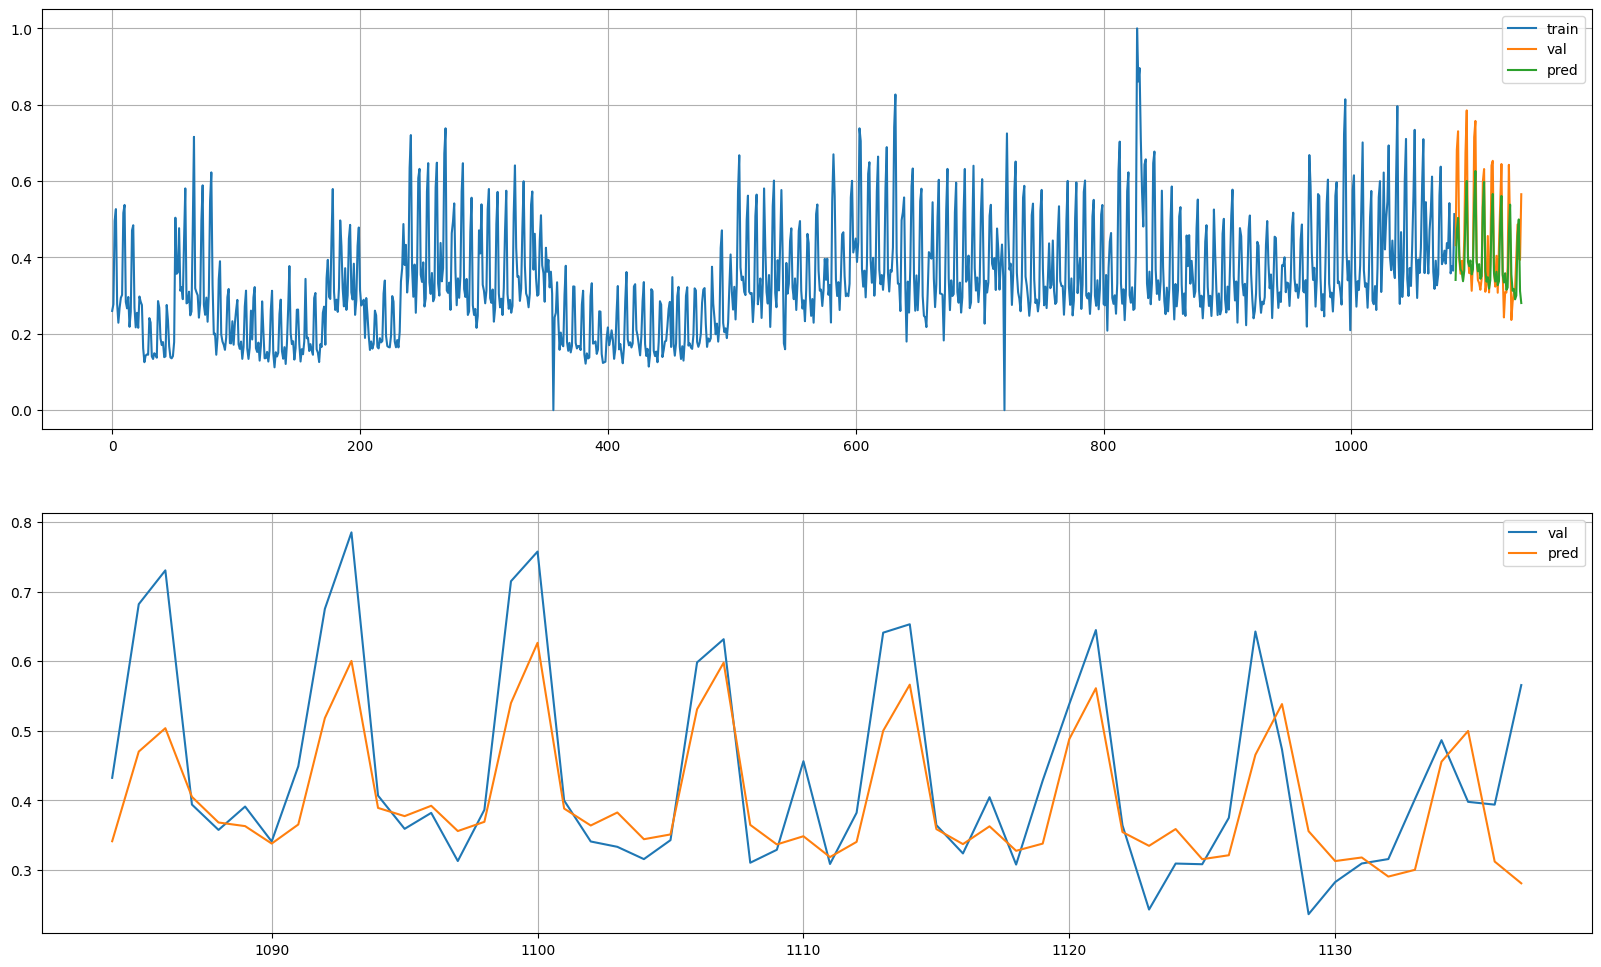

In [20]:
plot_model_result(y3_train_3d, y3_valid_3d, y3_pred_lstm)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [21]:
X12 = milk.drop(['y'], axis = 1)
y12 = milk['y']

X12_train, X12_valid, y12_train, y12_valid = X12.iloc[:-60], X12.iloc[-60:], y12.iloc[:-60], y12.iloc[-60:]

In [22]:
X12_train_3d, y12_train_3d = temporalize(X12_train, y12_train, 7)
X12_valid_3d, y12_valid_3d = temporalize(X12_valid, y12_valid, 7)

* **모델링**

In [23]:
clear_session()

model12_lstm = Sequential()
model12_lstm.add(LSTM(64, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model12_lstm.add(Dense(32, activation='relu'))
model12_lstm.add(Dense(16, activation='relu'))
model12_lstm.add(Dense(1))

In [24]:
model12_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model12_lstm.fit(X12_train_3d, y12_train_3d, epochs=50, batch_size=16, validation_data=(X12_valid_3d, y12_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0141
Epoch 1: val_loss improved from 0.00596 to 0.00497, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0140 - val_loss: 0.0050
Epoch 2/50
60/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 2: val_loss improved from 0.00497 to 0.00438, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 3/50
57/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 3: val_loss improved from 0.00438 to 0.00319, saving model to best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 4/50
57/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051
Epoch 4: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 5/50
58/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 5: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

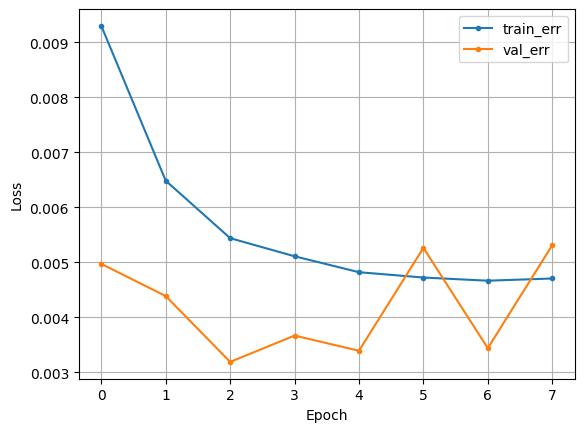

In [25]:
dl_history_plot(history.history)

In [26]:
y12_pred_lstm = model12_lstm.predict(X12_valid_3d)



# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y12_valid_3d, y12_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y12_valid_3d, y12_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y12_valid_3d, y12_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y12_valid_3d, y12_pred_lstm), 3)}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
RMSE : 0.073
MAE : 0.056
MAPE : 0.167
R2 : 0.251


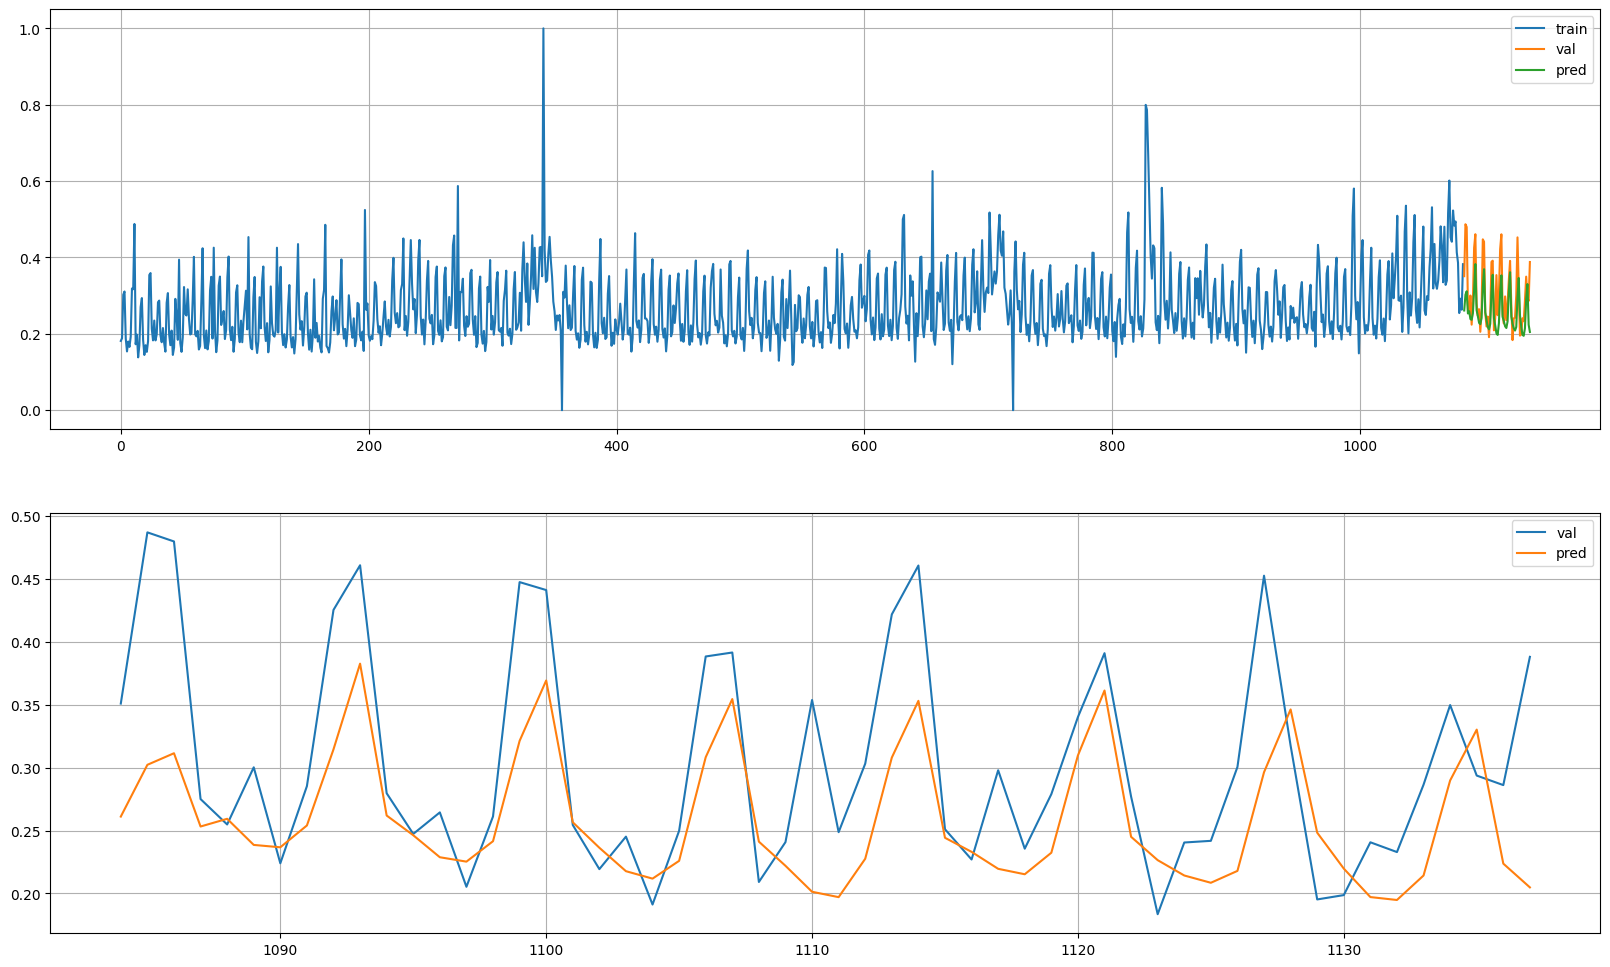

In [27]:
plot_model_result(y12_train_3d, y12_valid_3d, y12_pred_lstm)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [28]:
X42 = agri.drop(['y'], axis = 1)
y42 = agri['y']

X42_train, X42_valid, y42_train, y42_valid = X42.iloc[:-60], X42.iloc[-60:], y42.iloc[:-60], y42.iloc[-60:]

In [29]:
X42_train_3d, y42_train_3d = temporalize(X42_train, y42_train, 7)
X42_valid_3d, y42_valid_3d = temporalize(X42_valid, y42_valid, 7)

* **모델링**

In [30]:
clear_session()

model42_lstm = Sequential()
model42_lstm.add(LSTM(64, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model42_lstm.add(Dense(1))

In [31]:
model42_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model42_lstm.fit(X12_train_3d, y12_train_3d, epochs=50, batch_size=16, validation_data=(X12_valid_3d, y12_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0210
Epoch 1: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0208 - val_loss: 0.0083
Epoch 2/50
64/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 2: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 3/50
59/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 3: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0046
Epoch 4/50
64/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 4: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 5/50
63/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 5: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 5: early stopping


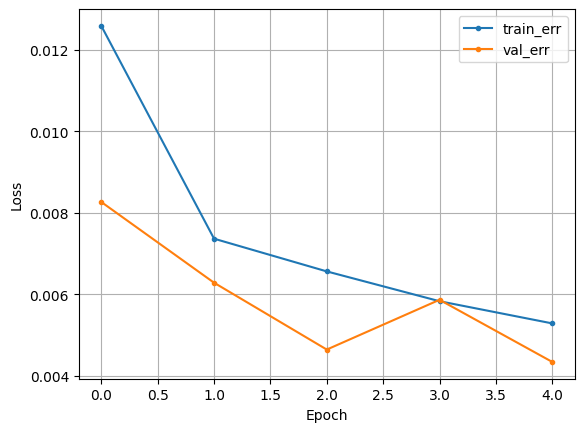

In [32]:
dl_history_plot(history.history)

In [33]:
y42_pred_lstm = model42_lstm.predict(X42_valid_3d)

# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y42_valid_3d, y42_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y42_valid_3d, y42_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y42_valid_3d, y42_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y42_valid_3d, y42_pred_lstm), 3)}')

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
RMSE : 0.095
MAE : 0.076
MAPE : 0.357
R2 : 0.122


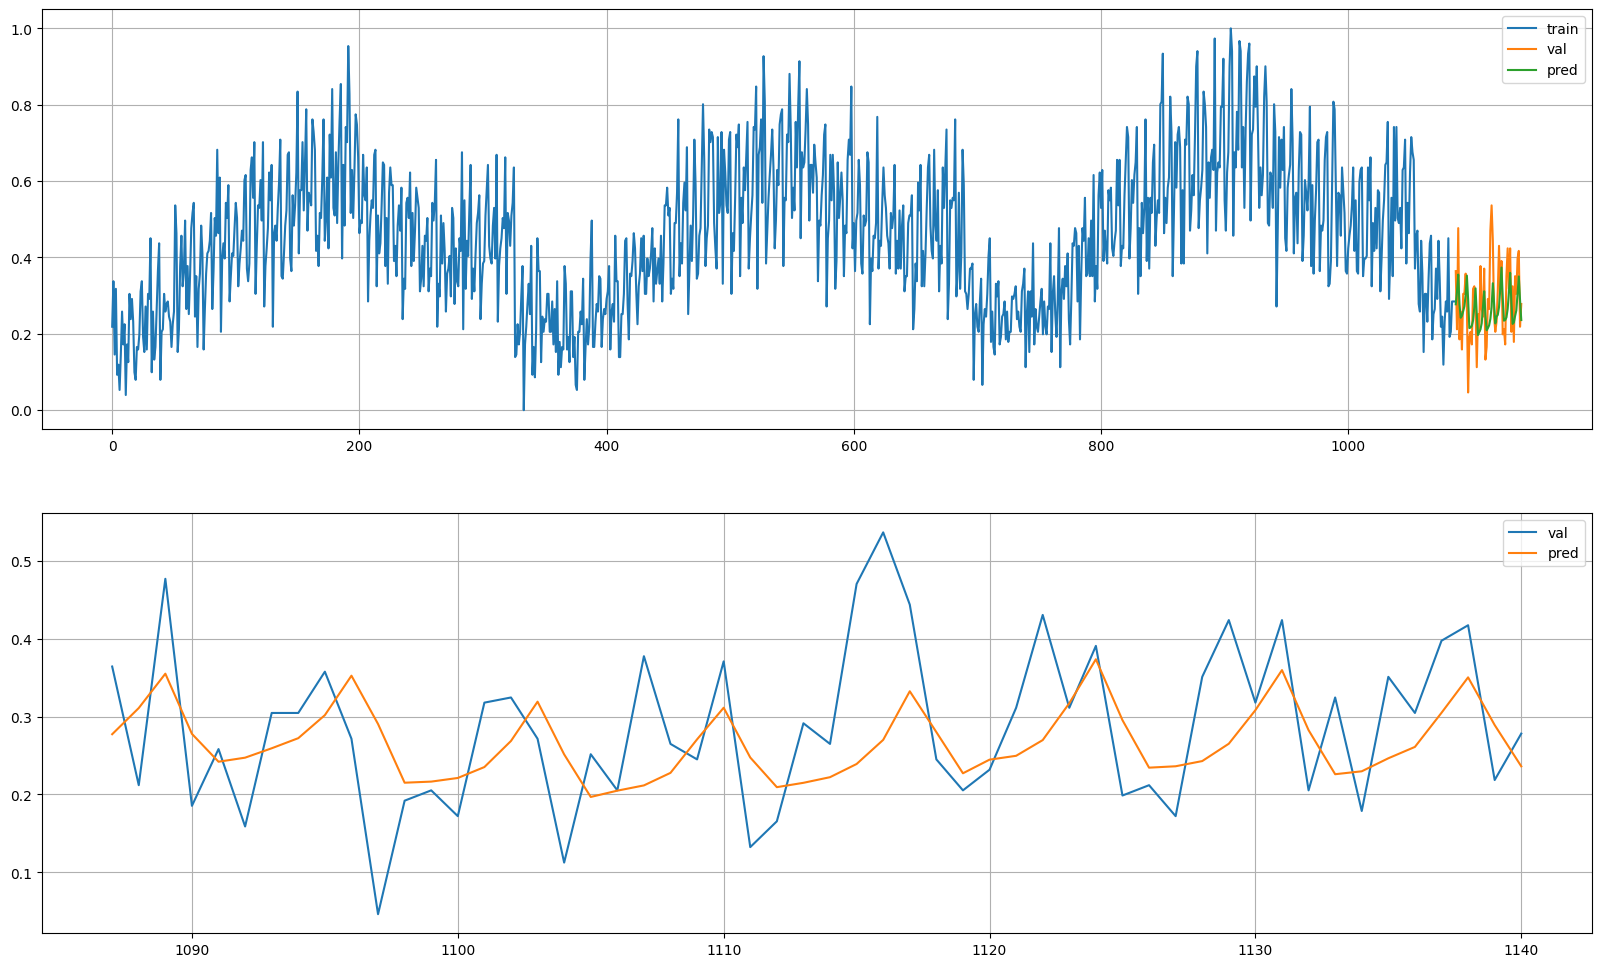

In [34]:
plot_model_result(y42_train_3d, y42_valid_3d, y42_pred_lstm)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [35]:
X3 = beverage.drop(['y'], axis = 1)
y3 = beverage['y']

X3_train, X3_valid, y3_train, y3_valid = X3.iloc[:-60], X3.iloc[-60:], y3.iloc[:-60], y3.iloc[-60:]

In [36]:
X3_train_3d, y3_train_3d = temporalize(X3_train, y3_train, 7)
X3_valid_3d, y3_valid_3d = temporalize(X3_valid, y3_valid, 7)

* **모델링**

In [37]:
clear_session()

model3_cnn = Sequential()
model3_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model3_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model3_cnn.add(MaxPooling1D(pool_size=2))
model3_cnn.add(Flatten())
model3_cnn.add(Dense(16, activation='relu'))
model3_cnn.add(Dense(1))

In [38]:
model3_cnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model3_cnn.fit(X3_train_3d, y3_train_3d, epochs=50, batch_size=16, validation_data=(X3_valid_3d, y3_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0882
Epoch 1: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0874 - val_loss: 0.0153
Epoch 2/50
58/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 2: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 3/50
64/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 3: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0081
Epoch 4/50
64/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 4: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 5/50
63/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 5: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 5: early stopping


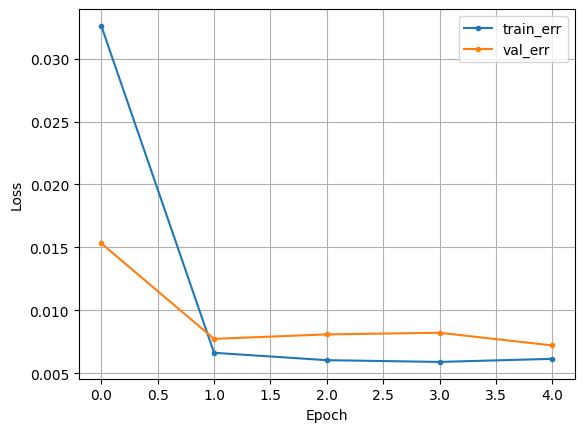

In [39]:
dl_history_plot(history.history)

In [40]:
y3_pred_cnn = model3_cnn.predict(X3_valid_3d)

# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y3_valid_3d, y3_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y3_valid_3d, y3_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y3_valid_3d, y3_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y3_valid_3d, y3_pred_cnn), 3)}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
RMSE : 0.085
MAE : 0.06
MAPE : 0.135
R2 : 0.655


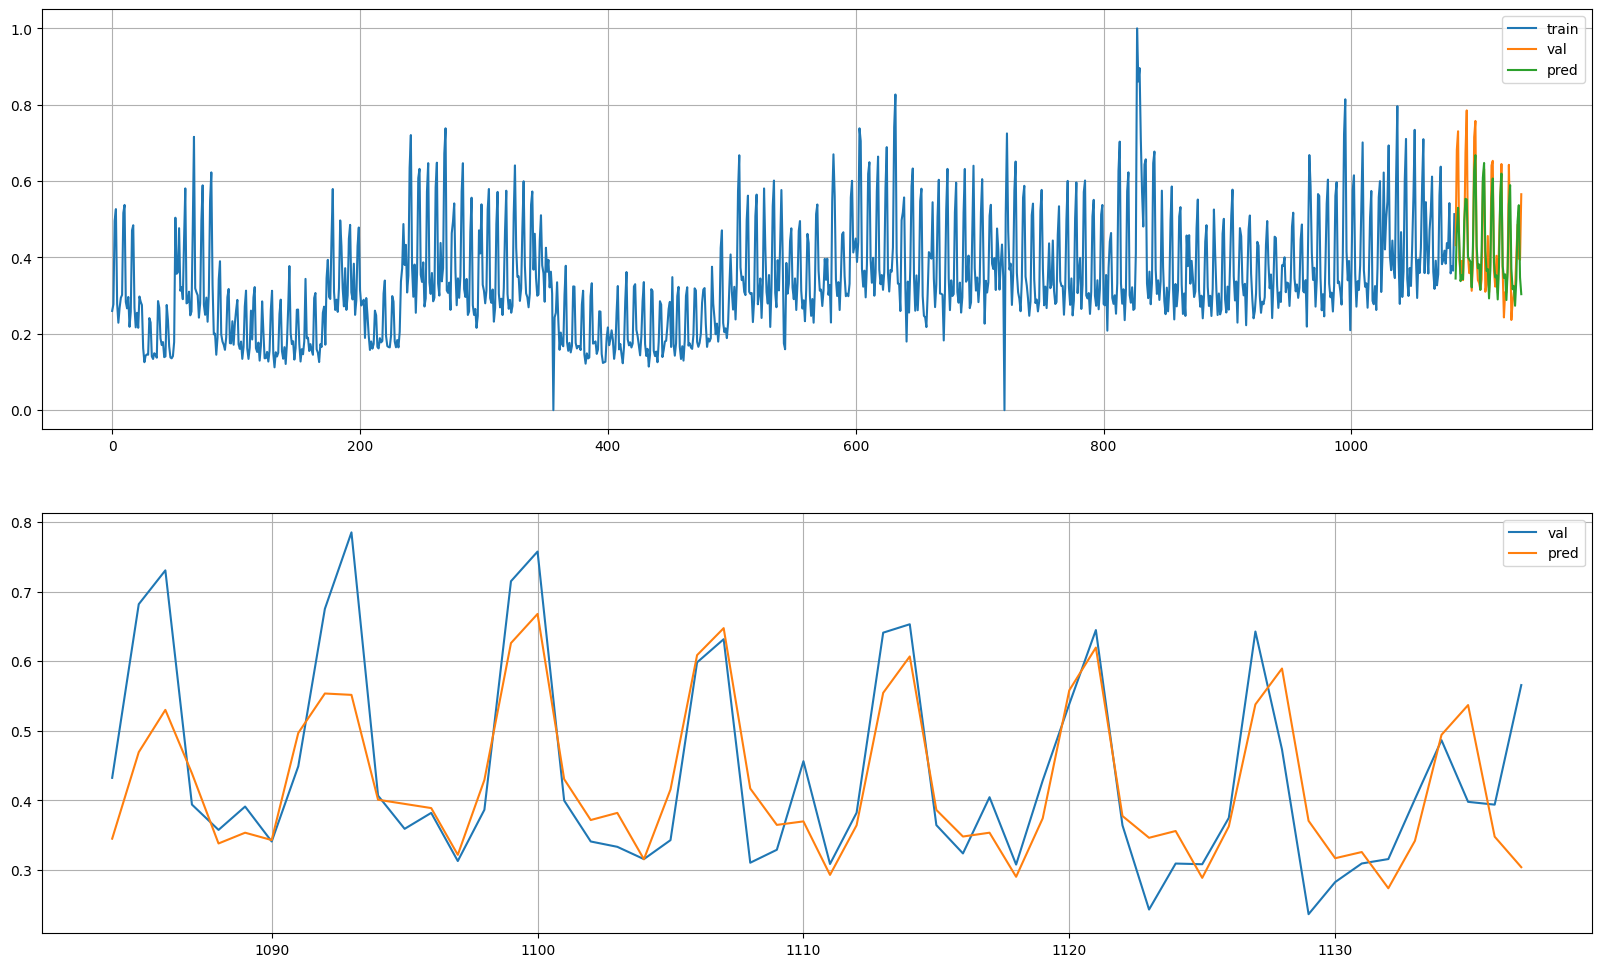

In [41]:
plot_model_result(y3_train_3d, y3_valid_3d, y3_pred_cnn)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [42]:
X12 = milk.drop(['y'], axis = 1)
y12 = milk['y']

X12_train, X12_valid, y12_train, y12_valid = X12.iloc[:-60], X12.iloc[-60:], y12.iloc[:-60], y12.iloc[-60:]

In [43]:
X12_train_3d, y12_train_3d = temporalize(X12_train, y12_train, 7)
X12_valid_3d, y12_valid_3d = temporalize(X12_valid, y12_valid, 7)

* **모델링**

In [44]:
clear_session()

model12_cnn = Sequential()
model12_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model12_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model12_cnn.add(MaxPooling1D(pool_size=2))
model12_cnn.add(Flatten())
model12_cnn.add(Dense(16, activation='relu'))
model12_cnn.add(Dense(1))

In [45]:
model12_cnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model12_cnn.fit(X12_train_3d, y12_train_3d, epochs=50, batch_size=16, validation_data=(X12_valid_3d, y12_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120
Epoch 1: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0120 - val_loss: 0.0056
Epoch 2/50
65/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 2: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 3/50
62/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 3: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 4/50
56/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 4: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 5/50
62/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 5: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5: early stopping


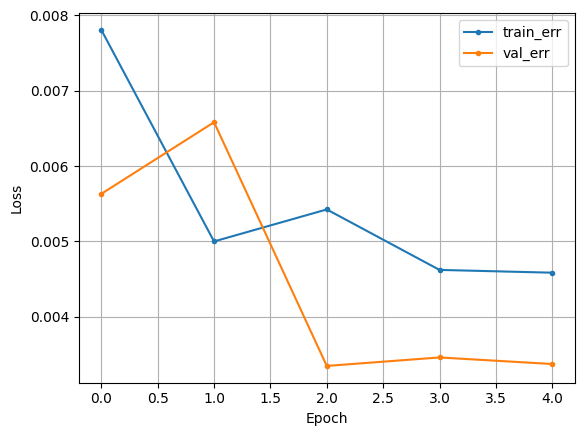

In [46]:
dl_history_plot(history.history)

In [47]:
y12_pred_cnn = model12_cnn.predict(X12_valid_3d)

# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y12_valid_3d, y12_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y12_valid_3d, y12_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y12_valid_3d, y12_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y12_valid_3d, y12_pred_cnn), 3)}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
RMSE : 0.058
MAE : 0.048
MAPE : 0.169
R2 : 0.524


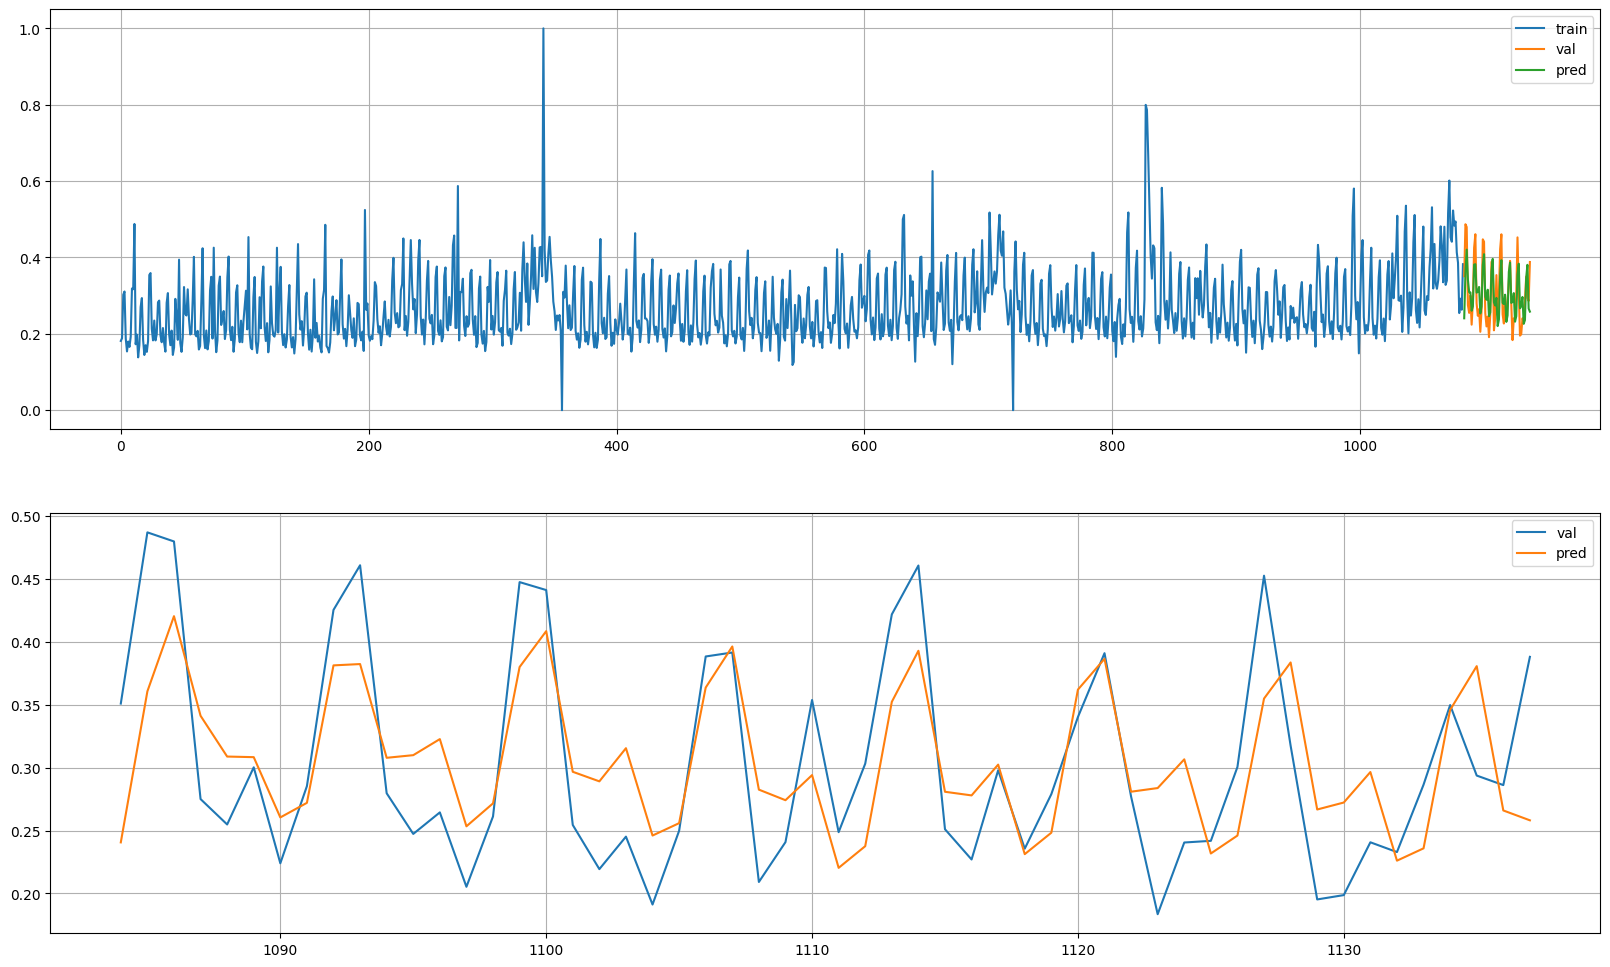

In [48]:
plot_model_result(y12_train_3d, y12_valid_3d, y12_pred_cnn)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [49]:
X42 = agri.drop(['y'], axis = 1)
y42 = agri['y']

X42_train, X42_valid, y42_train, y42_valid = X42.iloc[:-60], X42.iloc[-60:], y42.iloc[:-60], y42.iloc[-60:]

In [50]:
X42_train_3d, y42_train_3d = temporalize(X42_train, y42_train, 7)
X42_valid_3d, y42_valid_3d = temporalize(X42_valid, y42_valid, 7)

* **모델링**

In [51]:
clear_session()

model42_cnn = Sequential()
model42_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X3_train_3d.shape[1], X3_train_3d.shape[2])))
model42_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model42_cnn.add(MaxPooling1D(pool_size=2))
model42_cnn.add(Flatten())
model42_cnn.add(Dense(16, activation='relu'))
model42_cnn.add(Dense(1))

In [52]:
model42_cnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
history = model42_cnn.fit(X42_train_3d, y42_train_3d, epochs=50, batch_size=16, validation_data=(X42_valid_3d, y42_valid_3d), callbacks=[es, mcp])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0200
Epoch 1: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0199 - val_loss: 0.0076
Epoch 2/50
59/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 2: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 3/50
47/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 3: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 4/50
62/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 4: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 5/50
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 5: val_loss did not improve from 0.00319
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 5: early stopping


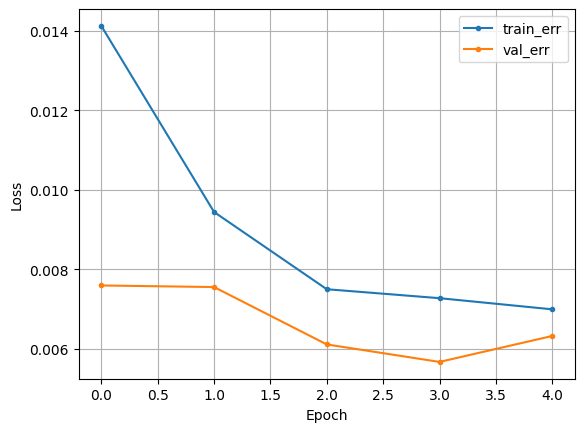

In [53]:
dl_history_plot(history.history)

In [54]:
y42_pred_cnn = model42_cnn.predict(X42_valid_3d)

# RMSE, MAE, MAPE, R2를 소수 셋째 자리까지 출력
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y42_valid_3d, y42_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y42_valid_3d, y42_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y42_valid_3d, y42_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y42_valid_3d, y42_pred_cnn), 3)}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
RMSE : 0.08
MAE : 0.062
MAPE : 0.233
R2 : 0.386


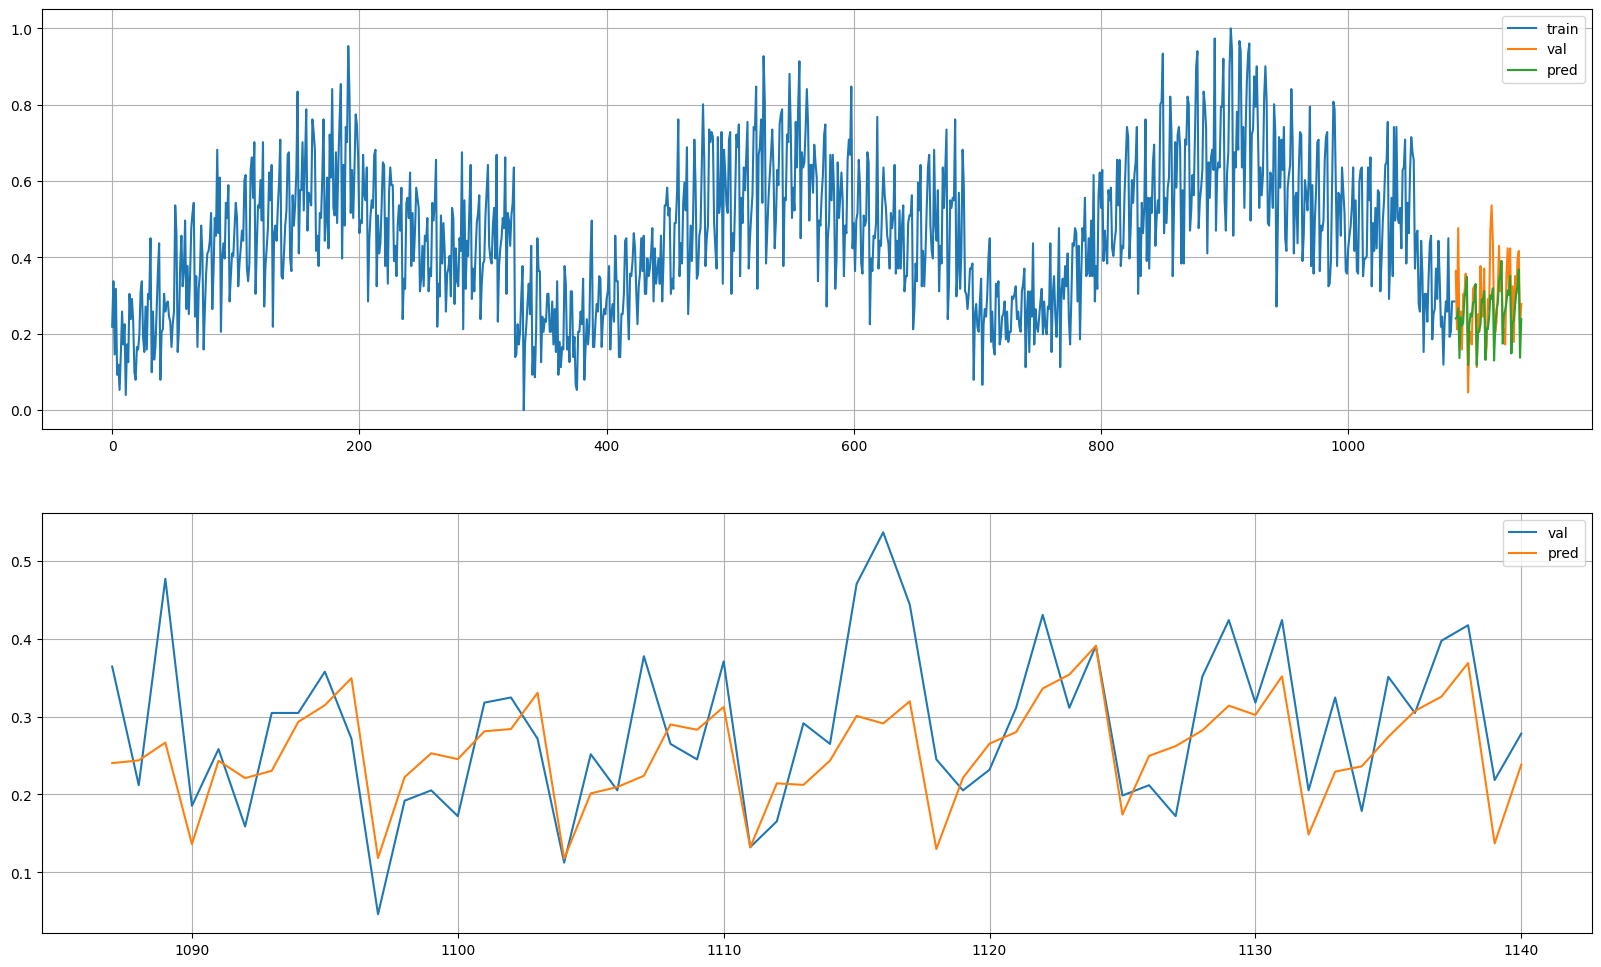

In [55]:
plot_model_result(y42_train_3d, y42_valid_3d, y42_pred_cnn)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [56]:
def data_pipeline(sales, orders, id):
    df = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == id)]
    df = df.merge(orders, how='left', on=['Date', 'Store_ID'])
    df = df.drop(['Store_ID', 'Product_ID'], axis = 1)

    df['CustomerCount'] = df['CustomerCount'].fillna(0)

    df['Qty_RM7'] = df['Qty'].rolling(7, min_periods=1).mean()

    df['Qty_RM14'] = df['Qty'].rolling(14, min_periods=1).mean()

    df['Customer_RM7'] = df['CustomerCount'].rolling(7, min_periods=1).mean()

    df['Customer_RM14'] = df['CustomerCount'].rolling(14, min_periods=1).mean()

    df['Qty_before_5d'] = df['Qty'].shift(5)
    df['Qty_before_5d'] = df['Qty_before_5d'].fillna(df['Qty'])

    df['Customer_before_5d'] = df['CustomerCount'].shift(5)
    df['Customer_before_5d'] = df['Customer_before_5d'].fillna(df['CustomerCount'])

    df['Qty_before_7d'] = df['Qty'].shift(7)
    df['Qty_before_7d'] = df['Qty_before_7d'].fillna(df['Qty'])

    df['Customer_before_7d'] = df['CustomerCount'].shift(7)
    df['Customer_before_7d'] = df['Customer_before_7d'].fillna(df['CustomerCount'])

    df['Weekend'] = df['Date'].dt.dayofweek.apply(lambda x: 1 if x in [5, 6] else 0)

    df['Season'] = df['Date'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
    df['Season_Spring'] = df['Season'].apply(lambda x: 1 if x == 'Spring' else 0)
    df['Season_Summer'] = df['Season'].apply(lambda x: 1 if x == 'Summer' else 0)
    df['Season_Winter'] = df['Season'].apply(lambda x: 1 if x == 'Winter' else 0)
    df = df.drop('Season', axis = 1)

    df = df.replace({False: 0, True: 1})

    df['Holiday'] = df['Date'].apply(lambda x: 1 if x.month == 1 and x.day == 1 else 0)

    df['y'] = df['Qty'].shift(-2)
    # df['y'] = df['y'].fillna(method='bfill')

    df = df.iloc[:-2]
    df = df.set_index('Date')

    print(df)
    origin_df = df.copy()

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)

    X = df.drop('y', axis = 1)
    y = df['y']

    X_3d, y_3d = temporalize(X, y, 7)

    return X_3d, y_3d, origin_df

In [57]:
X3, y3, origin_df3 = data_pipeline(sales, orders, 3)
X12, y12, origin_df12 = data_pipeline(sales, orders, 12)
X42, y42, origin_df42 = data_pipeline(sales, orders, 42)

                Qty  CustomerCount      Qty_RM7     Qty_RM14  Customer_RM7  \
Date                                                                         
2014-01-01      0.0            0.0     0.000000     0.000000      0.000000   
2014-01-02   9853.0         4422.0  4926.500000  4926.500000   2211.000000   
2014-01-03   8647.0         4167.0  6166.666667  6166.666667   2863.000000   
2014-01-04  15153.0         5341.0  8413.250000  8413.250000   3482.500000   
2014-01-05  15606.0         5123.0  9851.800000  9851.800000   3810.600000   
...             ...            ...          ...          ...           ...   
2017-02-22   7856.0         3834.0  9534.857143  9913.714286   3980.571429   
2017-02-23   8018.0         3955.0  9561.857143  9928.071429   3984.428571   
2017-02-24  10208.0         4549.0  9659.571429  9879.571429   4018.714286   
2017-02-25  12361.0         4619.0  9092.428571  9785.357143   3904.571429   
2017-02-26  10108.0         3877.0  8818.857143  9337.071429   3

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [58]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [59]:
X3_test, y3_test, origin_df3_test = data_pipeline(sales_test, orders_test, 3)
X12_test, y12_test, origin_df12_test = data_pipeline(sales_test, orders_test, 12)
X42_test, y42_test, origin_df42_test = data_pipeline(sales_test, orders_test, 42)

                Qty  CustomerCount       Qty_RM7      Qty_RM14  Customer_RM7  \
Date                                                                           
2017-03-01  10153.0           4146  10153.000000  10153.000000   4146.000000   
2017-03-02   8918.0           3882   9535.500000   9535.500000   4014.000000   
2017-03-03  10257.0           4483   9776.000000   9776.000000   4170.333333   
2017-03-04  16991.0           5382  11579.750000  11579.750000   4473.250000   
2017-03-05  18304.0           5423  12924.600000  12924.600000   4663.200000   
2017-03-06   8413.0           3882  12172.666667  12172.666667   4533.000000   
2017-03-07   8360.0           3828  11628.000000  11628.000000   4432.285714   
2017-03-08   8632.0           4111  11410.714286  11253.500000   4427.285714   
2017-03-09   8816.0           3560  11396.142857  10982.666667   4381.285714   
2017-03-10  10087.0           4183  11371.857143  10893.100000   4338.428571   
2017-03-11  15131.0           5080  1110

In [60]:
y3_pred_lstm = model3_lstm.predict(X3_test)
y3_pred_cnn = model3_cnn.predict(X3_test)

y12_pred_lstm = model12_lstm.predict(X12_test)
y12_pred_cnn = model12_cnn.predict(X12_test)

y42_pred_lstm = model42_lstm.predict(X42_test)
y42_pred_cnn = model42_cnn.predict(X42_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


### 예측: LSTM - Beverage

In [61]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y3_test, y3_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y3_test, y3_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y3_test, y3_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y3_test, y3_pred_lstm), 3)}')

RMSE : 0.2
MAE : 0.158
MAPE : 55696412285907.92
R2 : 0.481


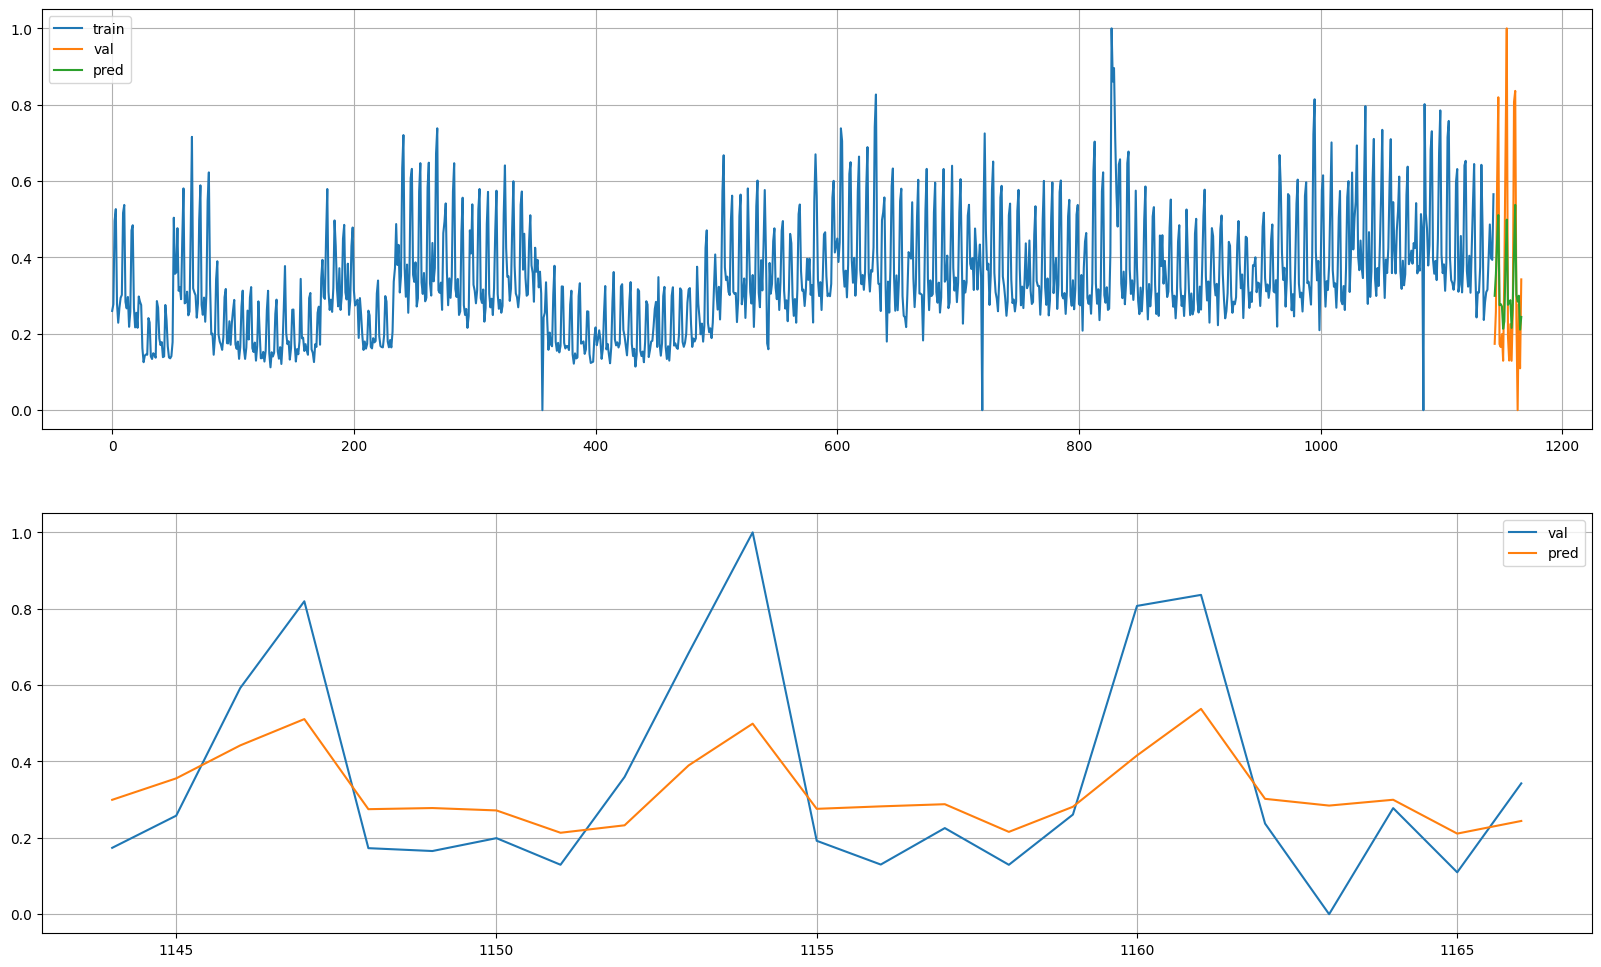

In [62]:
plot_model_result(y3, y3_test, y3_pred_lstm)

### 예측: LSTM - Milk

In [63]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y12_test, y12_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y12_test, y12_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y12_test, y12_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y12_test, y12_pred_lstm), 3)}')

RMSE : 0.209
MAE : 0.158
MAPE : 44330636245615.65
R2 : 0.291


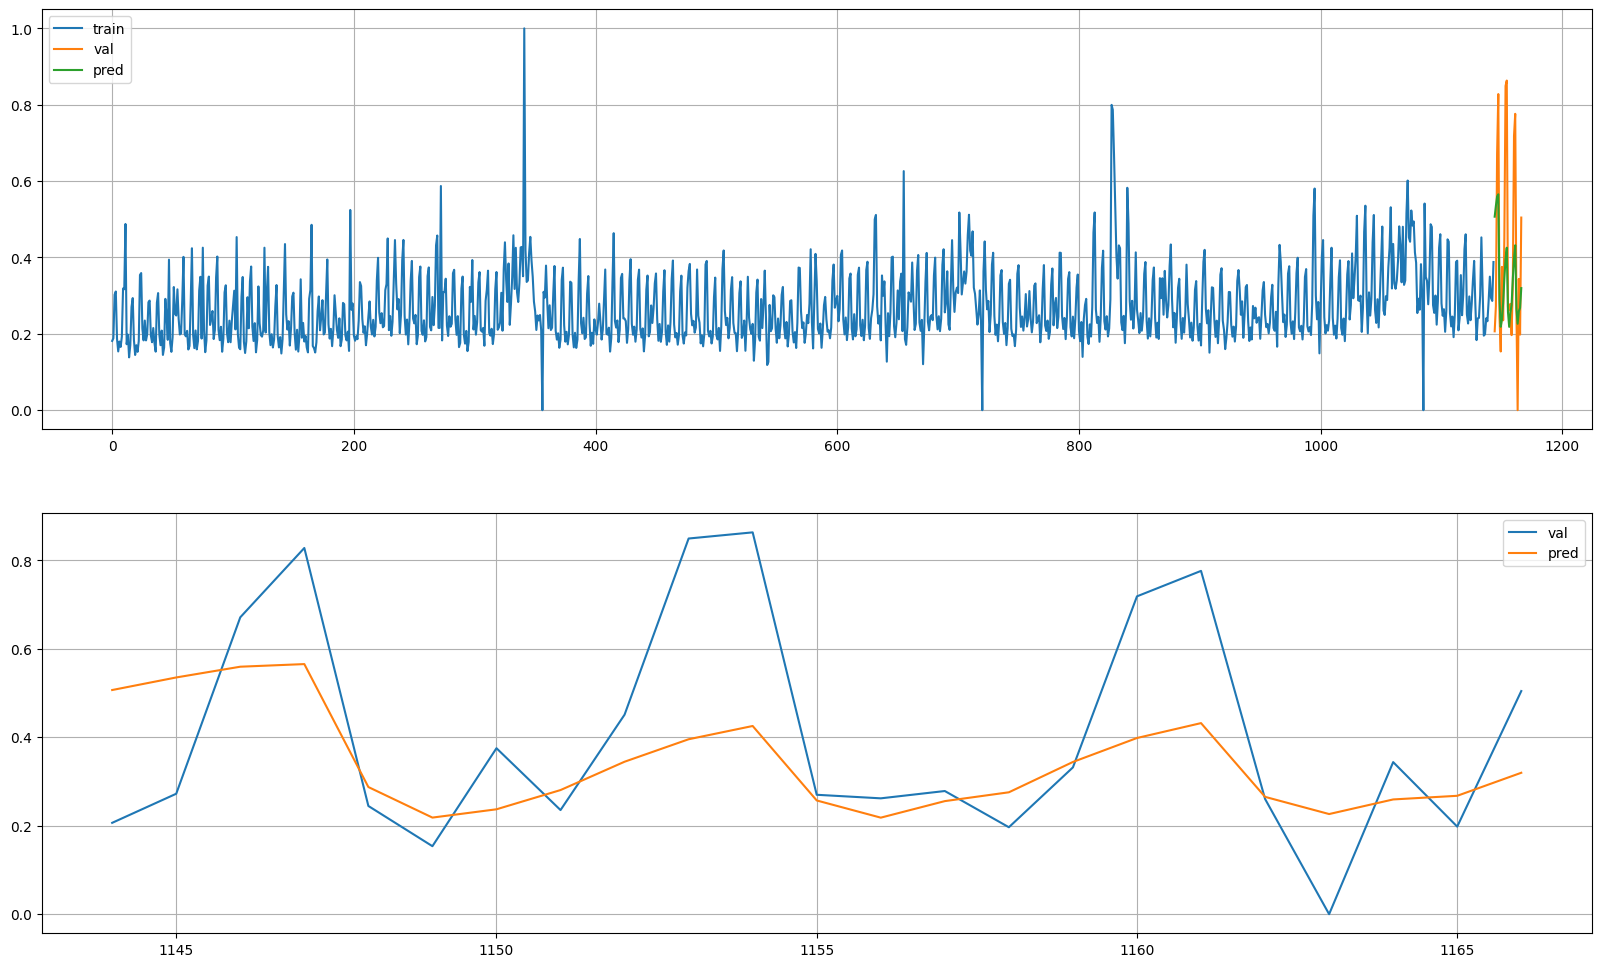

In [64]:
plot_model_result(y12, y12_test, y12_pred_lstm)

### 예측: LSTM - Agricultural

In [65]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y42_test, y42_pred_lstm)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y42_test, y42_pred_lstm), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y42_test, y42_pred_lstm), 3)}')
print(f'R2 : {np.round(r2_score(y42_test, y42_pred_lstm), 3)}')

RMSE : 0.228
MAE : 0.181
MAPE : 2.394
R2 : 0.162


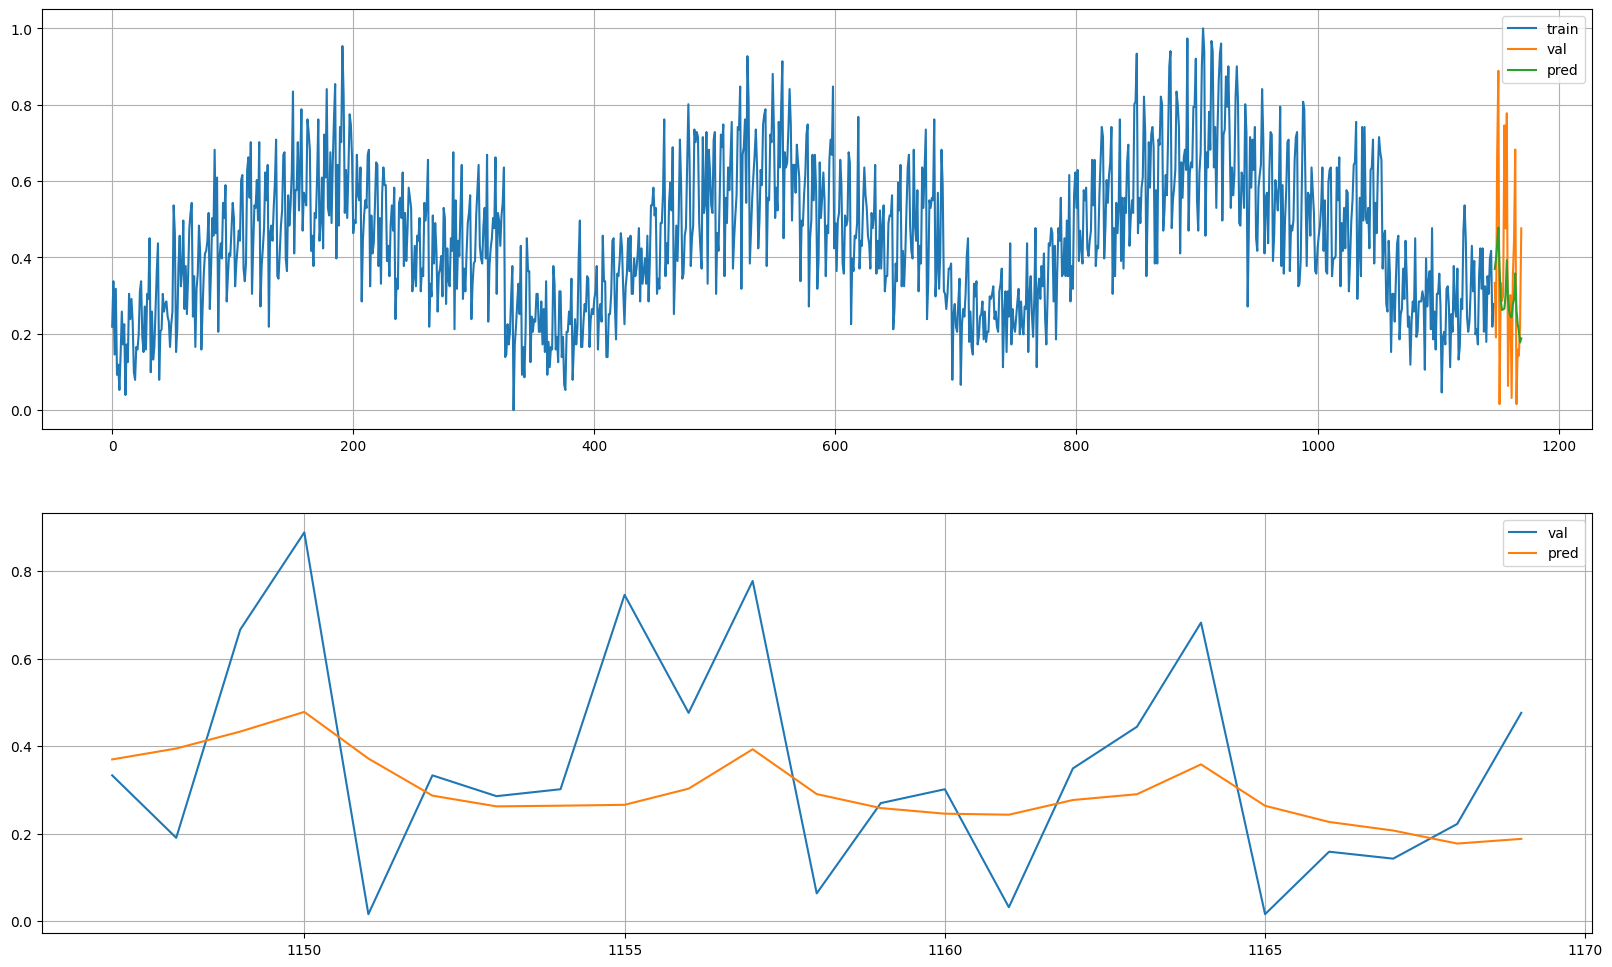

In [66]:
plot_model_result(y42, y42_test, y42_pred_lstm)

### 예측: CNN - Beverage

In [67]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y3_test, y3_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y3_test, y3_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y3_test, y3_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y3_test, y3_pred_cnn), 3)}')

RMSE : 0.156
MAE : 0.133
MAPE : 75355376274922.27
R2 : 0.686


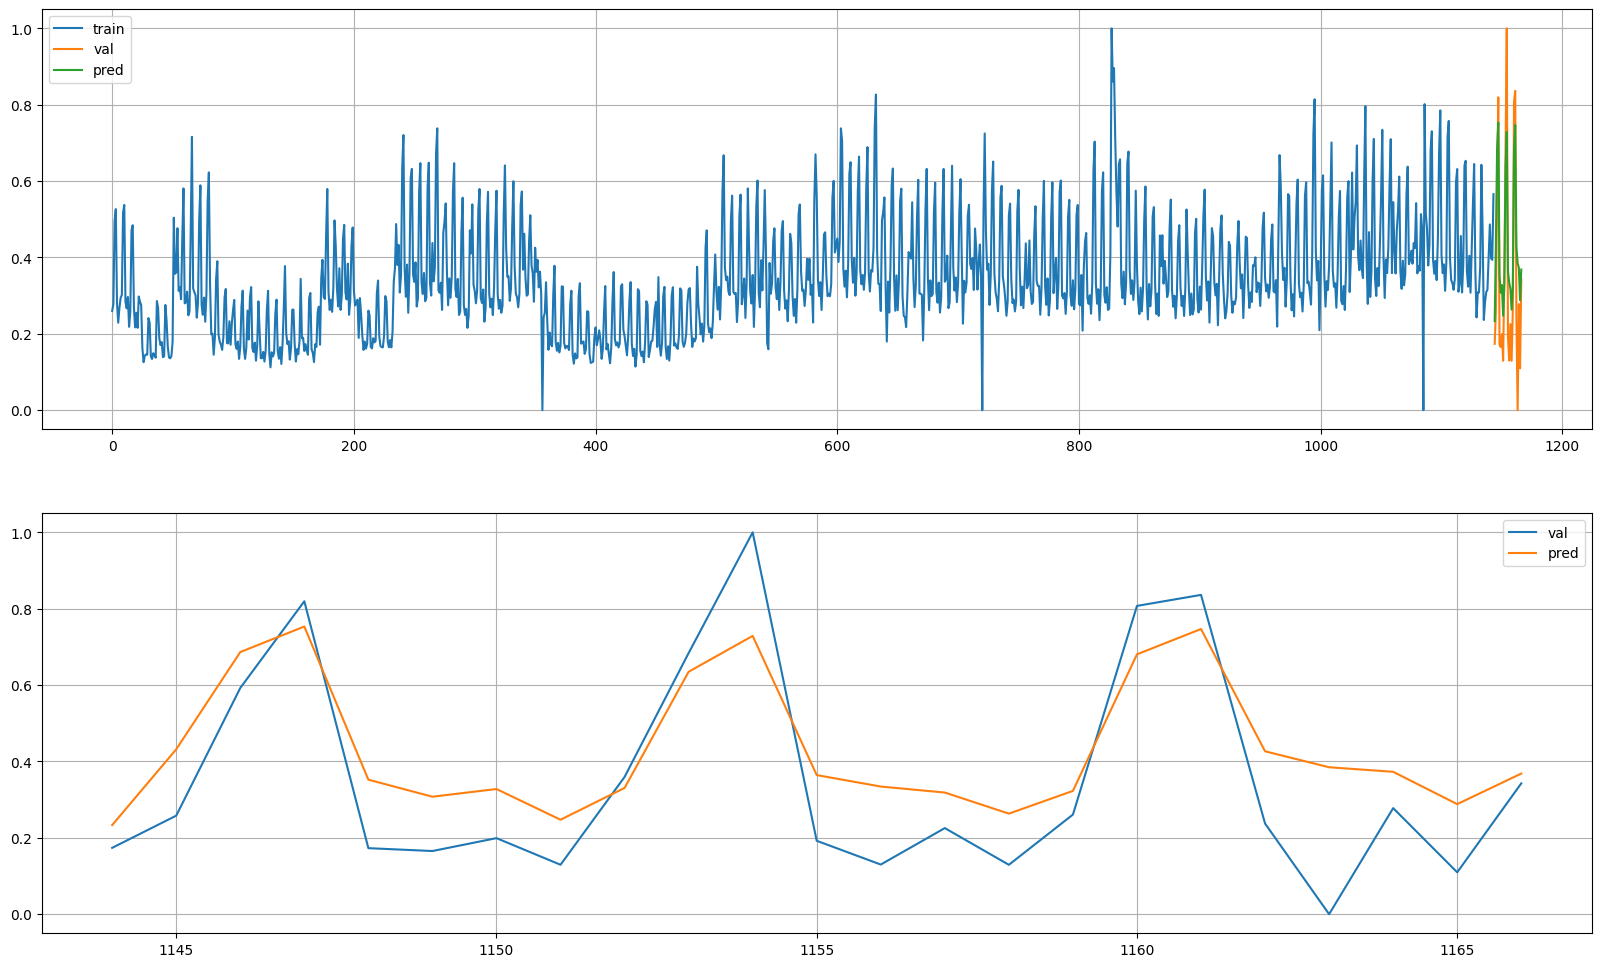

In [68]:
plot_model_result(y3, y3_test, y3_pred_cnn)

### 예측: CNN - Milk

In [69]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y12_test, y12_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y12_test, y12_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y12_test, y12_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y12_test, y12_pred_cnn), 3)}')

RMSE : 0.222
MAE : 0.168
MAPE : 42371678903251.8
R2 : 0.198


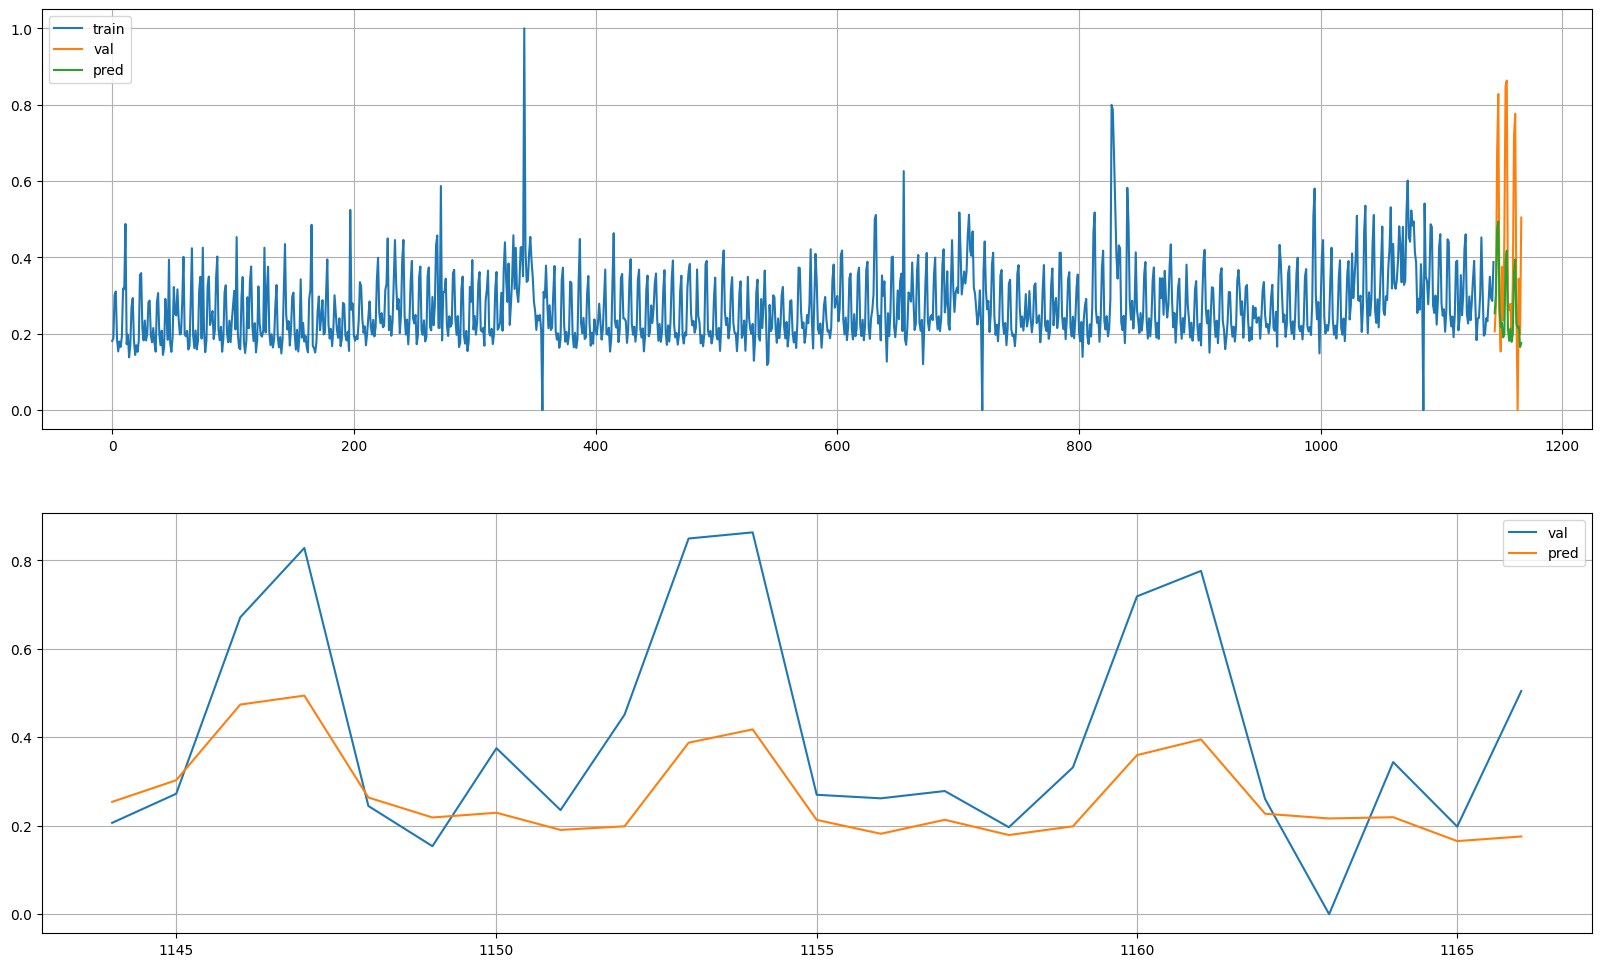

In [70]:
plot_model_result(y12, y12_test, y12_pred_cnn)

### 예측: CNN - Agricultural

In [71]:
print(f'RMSE : {np.round(np.sqrt(mean_squared_error(y42_test, y42_pred_cnn)), 3)}')
print(f'MAE : {np.round(mean_absolute_error(y42_test, y42_pred_cnn), 3)}')
print(f'MAPE : {np.round(mean_absolute_percentage_error(y42_test, y42_pred_cnn), 3)}')
print(f'R2 : {np.round(r2_score(y42_test, y42_pred_cnn), 3)}')

RMSE : 0.235
MAE : 0.19
MAPE : 2.423
R2 : 0.112


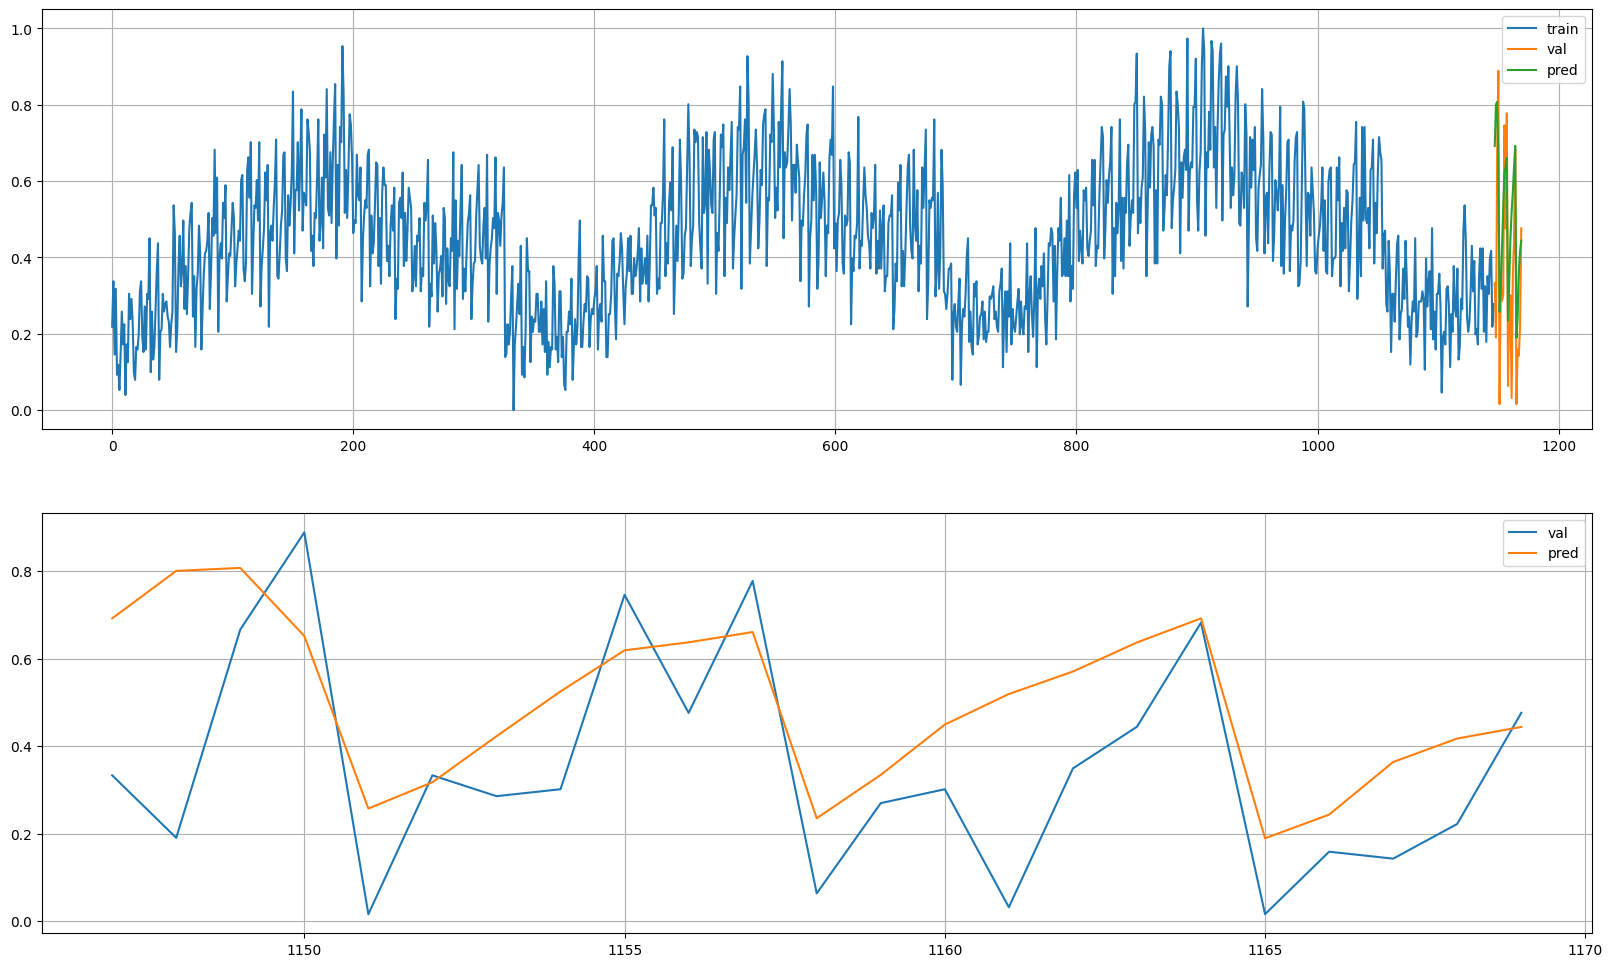

In [72]:
plot_model_result(y42, y42_test, y42_pred_cnn)

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_scaled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [73]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [74]:
s_stock3 = 16000
s_stock12 = 18000
s_stock42 = 70

### 예측: LSTM - Beverage

In [75]:
y_max = origin_df3_test['y'].max()
y_min = origin_df3_test['y'].min()

y_real = y3_test * (y_max - y_min) + y_min
pred_real = y3_pred_lstm * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 3].iloc[0]['Price']

In [76]:
inv = inv_simulator(y_real, pred_real, s_stock3, price)

일평균 재고량     : 23261.69
일평균 재고 금액  : 186093.52
일평균 재고회전율 : 0.727
기회손실 수량     : -6975.0


### 예측: LSTM - Milk

In [77]:
y_max = origin_df12_test['y'].max()
y_min = origin_df12_test['y'].min()

y_real = y12_test * (y_max - y_min) + y_min
pred_real = y12_pred_lstm * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 12].iloc[0]['Price']

In [78]:
inv = inv_simulator(y_real, pred_real, s_stock12, price)

일평균 재고량     : 23290.405
일평균 재고 금액  : 139742.43
일평균 재고회전율 : 0.566
기회손실 수량     : 0.0


### 예측: LSTM - Agricultural


In [79]:
y_max = origin_df42_test['y'].max()
y_min = origin_df42_test['y'].min()

y_real = y42_test * (y_max - y_min) + y_min
pred_real = y42_pred_lstm * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 42].iloc[0]['Price']

In [80]:
inv = inv_simulator(y_real, pred_real, s_stock42, price)

일평균 재고량     : 124.786
일평균 재고 금액  : 623.9300000000001
일평균 재고회전율 : 1.027
기회손실 수량     : -13.0


### 예측: CNN - Beverage

In [81]:
y_max = origin_df3_test['y'].max()
y_min = origin_df3_test['y'].min()

y_real = y3_test * (y_max - y_min) + y_min
pred_real = y3_pred_cnn * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 3].iloc[0]['Price']

In [82]:
inv = inv_simulator(y_real, pred_real, s_stock3, price)

일평균 재고량     : 23840.905
일평균 재고 금액  : 190727.24
일평균 재고회전율 : 0.548
기회손실 수량     : 0.0


### 예측: CNN - Milk

In [83]:
y_max = origin_df12_test['y'].max()
y_min = origin_df12_test['y'].min()

y_real = y12_test * (y_max - y_min) + y_min
pred_real = y12_pred_cnn * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 12].iloc[0]['Price']

In [84]:
inv = inv_simulator(y_real, pred_real, s_stock12, price)

일평균 재고량     : 22923.357
일평균 재고 금액  : 137540.142
일평균 재고회전율 : 0.6
기회손실 수량     : 0.0


### 예측: CNN - Agricultural

In [85]:
y_max = origin_df42_test['y'].max()
y_min = origin_df42_test['y'].min()

y_real = y42_test * (y_max - y_min) + y_min
pred_real = y42_pred_cnn * (y_max - y_min) + y_min

price = products[products['Product_ID'] == 42].iloc[0]['Price']

In [86]:
inv = inv_simulator(y_real, pred_real, s_stock42, price)

일평균 재고량     : 133.381
일평균 재고 금액  : 666.905
일평균 재고회전율 : 0.847
기회손실 수량     : 0.0
